In [1]:
import pandas as pd  #import the necessary libraries.
import numpy as np 
import math as mt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = "{:,.2f}".format

In [2]:
def weekly_coverage(df):
    results = []

    for index, row in df.iterrows():
        beg_inventory = row['Beg_Inventory-X']
        forecast_columns = [col for col in df.columns if col.startswith('FC-X')]
        
        # Initialize remaining inventory with the beginning inventory
        remaining_inventory = beg_inventory
        full_weeks_covered = 0
        
        for i, fc in enumerate(forecast_columns):
            forecasted_amount = row[fc]
            
            if remaining_inventory >= forecasted_amount:
                # If remaining inventory covers the forecasted amount, continue
                remaining_inventory -= forecasted_amount
                full_weeks_covered += 4
            else:
                # Calculate the fractional coverage if remaining inventory is less than forecasted amount
                fractional_coverage = remaining_inventory / forecasted_amount if forecasted_amount != 0 else 0
                fractional_weeks = fractional_coverage * 4  # since each period represents 4 weeks
                total_coverage = full_weeks_covered + fractional_weeks
                results.append(total_coverage)
                break
        else:
            # If all forecasts are covered without running out of inventory
            results.append(full_weeks_covered)

    return results



In [3]:
def twcv_assignment(df, WC_2, WC_3, WC_4, WC_5, twc1, twc2, twc3, twc4):
    """
    Assigns Targeted Weekly Cover Value (TWCV) based on DataFrame of capacity utilizations per month.

    Parameters:
    - df: DataFrame with columns as months and rows as capacity utilization entries.
    - WC_2, WC_3, WC_4, WC_5: Threshold values for TWCV assignment.
    - twc1, twc2, twc3, twc4: TWCV values to be assigned based on the computed thresholds.

    Returns:
    - DataFrame with the same structure containing TWCV values for each period.
    """
    W = 0.6  # Example weight, adjust as necessary
    twc_results = pd.DataFrame(index=df.index, columns=df.columns)  # prepare DataFrame to store results
    
    for index, row in df.iterrows():
        utilizations = row.values
        twc = []
        t = 0  

        while t < len(utilizations):
            if t + 3 < len(utilizations):
                C_t = W * max(utilizations[t], utilizations[t+1]) + \
                      (1 - W) * max(utilizations[t+2], utilizations[t+3])
            elif t + 2 < len(utilizations):
                C_t = W * max(utilizations[t], utilizations[t+1]) + \
                      (1 - W) * utilizations[t+2]
            elif t + 1 < len(utilizations):
                C_t = W * utilizations[t] + (1 - W) * utilizations[t+1]
            else:
                C_t = utilizations[t]

            # Assign TWCV based on the computed C_t
            if 0 <= C_t <= WC_2:
                twc.append(twc1)
            elif C_t <= WC_3:
                twc.append(twc2)
            elif C_t <= WC_4:
                twc.append(twc3)
            else:
                twc.append(twc4)
            
            t += 1  

        twc_results.loc[index] = twc 

    return twc_results

In [4]:
df= pd.read_csv(r'{PATH}')

In [5]:
df.iloc[:,4:18].head(3)

,Beg_Inventory-X,FC-X,FC-X+1,FC-X+2,FC-X+3,FC-X+4,FC-X+5,FC-X+6,FC-X+7,FC-X+8,FC-X+9,FC-X+10,FC-X+11,FC-X+12
0,4655,4305,2460,4305,3075,3690,4920,4920,3690,2460,1845,4115,4115,4115
1,24536,22694,9727,19758,17128,17096,13070,17120,14290,14082,11084,16000,11474,16452
2,5409,4884,7388,7653,5252,6308,8284,7562,8874,5103,4584,6466,3408,5268


In [6]:
wc_list=df.iloc[:,4:18]
df=df.assign(WC=weekly_coverage(wc_list))
display(df.iloc[:,-5:].tail())

,MOLDCAP_X+10,MOLDCAP_X+11,MOLDCAP_X+12,MOLDCAP_X+13,WC
142,637,626,637,523,8.80
143,1207,1186,1207,992,52.00
144,1207,1186,1207,992,52.00
145,1207,1186,1207,992,29.55
146,755,743,755,621,52.00


In [7]:
df.query("WC==52").iloc[:,6:10].head(4) #forecasted however positive inventory at the end of 14 months (15 prods) assigned 56 weeks as WC.

,FC-X+1,FC-X+2,FC-X+3,FC-X+4
13,0,0,0,0
15,0,0,0,0
16,0,0,0,2
17,0,0,0,0


In [8]:
filter1= df.query("WC<52").reset_index(drop=True) #get rid of non-forecasted ones. 
capacity_sufficiency_oe=(filter1.iloc[:,5:19].values / filter1.iloc[:,19:33].values) #(forecast/production_capacity)

In [9]:
filter1=pd.concat([filter1,pd.DataFrame(capacity_sufficiency_oe)], axis=1)
filter1=filter1.rename(columns={0: 'CS_11_2021', 1: 'CS_12_2021', 2: 'CS_01_2022', 3:'CS_02_2022',
                                4: 'CS_03_2022', 5: 'CS_04_2022', 6: 'CS_05_2022', 7:'CS_06_2022',
                                8: 'CS_07_2022', 9: 'CS_08_2022', 10: 'CS_09_2022',11:'CS_10_2022',
                                12:'CS_11_2022',13:'CS_12_2022'})

In [10]:
filter1.iloc[:,34:].head(2)

,CS_11_2021,CS_12_2021,CS_01_2022,CS_02_2022,CS_03_2022,CS_04_2022,CS_05_2022,CS_06_2022,CS_07_2022,CS_08_2022,CS_09_2022,CS_10_2022,CS_11_2022,CS_12_2022
0,0.81,0.49,0.97,0.62,0.67,0.96,1.07,0.69,0.58,0.35,0.77,0.79,0.77,0.94
1,0.69,0.32,0.73,0.56,0.51,0.41,0.60,0.44,0.54,0.34,0.49,0.36,0.50,0.50


In [11]:
df_capacity_suf=filter1.iloc[:,34:].copy()

In [12]:
WC_2 = 0.25
WC_3 = 0.50
WC_4 = 0.75
WC_5 = 1.00

twc1 = 2
twc2 = 3 #4 targeted WC values
twc3 = 4
twc4 = 5

twc_values = twcv_assignment(filter1.iloc[:,34:], WC_2, WC_3, WC_4, WC_5, twc1, twc2, twc3, twc4)

In [13]:
ndf=filter1.copy(deep=True)
twc_values = pd.DataFrame(twc_values)
twc_values.columns = ['0_monthly', '1_monthly', '2_monthly', '3_monthly', '4_monthly', '5_monthly', 
                      '6_monthly', '7_monthly', '8_monthly', '9_monthly', '10_monthly',
                      '11_monthly', '12_monthly', '13_monthly']
ndf=filter1.join(twc_values)

In [14]:
filter3=ndf[ndf['prod_group']=='PSR'] #company specific info

In [15]:
x=filter3.filter(like='CS').values.tolist()
wc=filter3['WC'].values.tolist()
prod_group=filter3['prod_group'].tolist()
prod_code=filter3['production_code'].tolist()
prod_description=filter3['prod_desc.'].tolist()
WC_targeted_1month=filter3.filter(like='monthly').values.tolist()
forecasted=filter3.iloc[:,5:19].values.tolist()

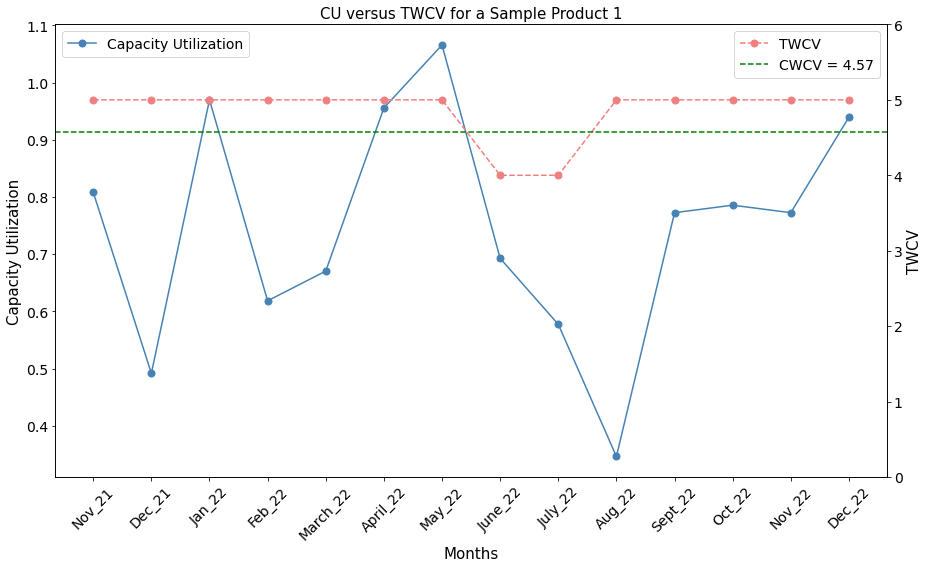

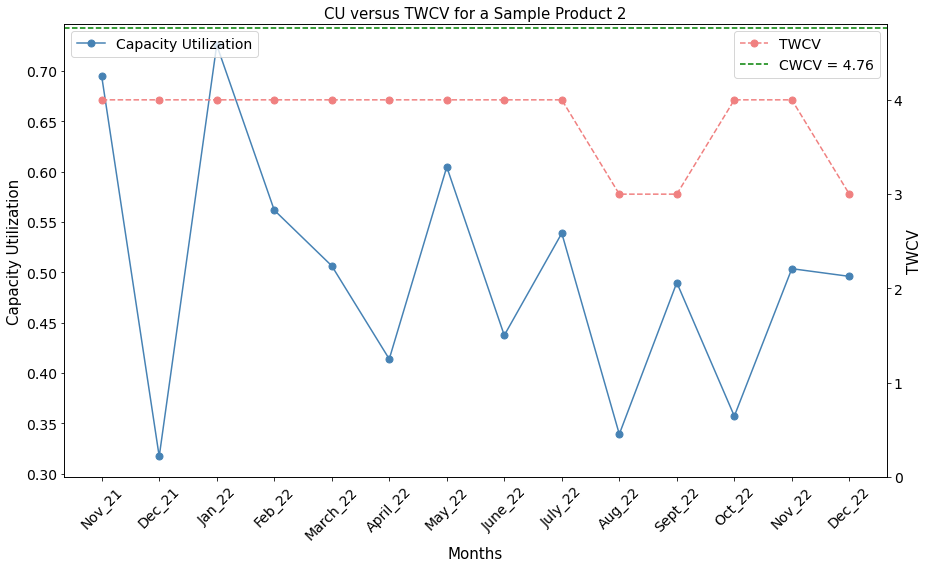

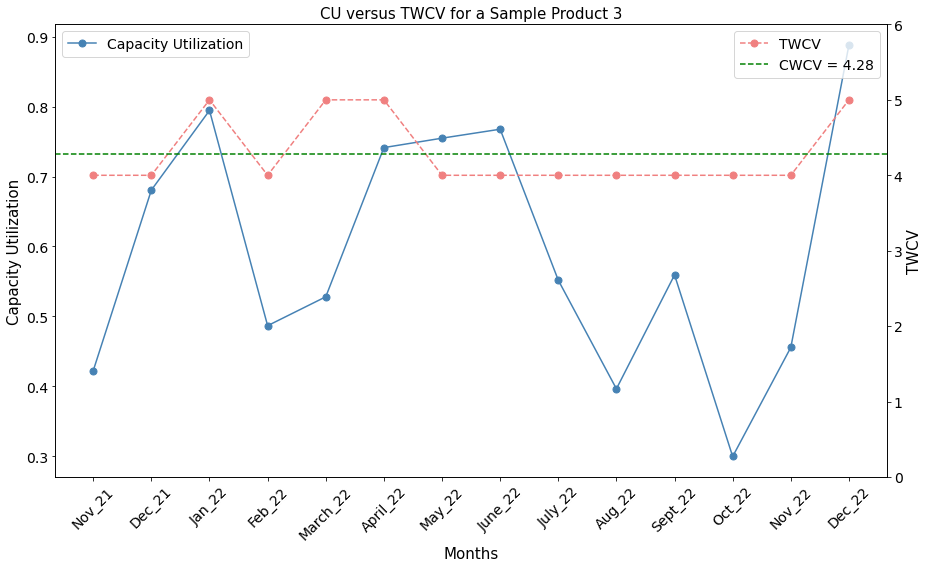

In [16]:
# Sample data setup
m = ['Nov_21', 'Dec_21', 'Jan_22', 'Feb_22', 'March_22', 'April_22', 'May_22',
     'June_22', 'July_22', 'Aug_22', 'Sept_22', 'Oct_22', 'Nov_22', 'Dec_22']
m_axis = np.arange(len(m))

plt.rcParams["figure.figsize"] = [13, 8]
plt.rcParams["figure.autolayout"] = True

for i in range(3): 
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(m, x[i], label="Capacity Utilization", marker='o', markersize=7, color='steelblue')
    ax2.plot(m, WC_targeted_1month[i], label='TWCV', marker='o', linestyle='dashed', color='lightcoral', markersize=7)
    ax2.axhline(y=wc[i], color='green', linestyle='--', label=f'CWCV = {wc[i]:.2f}')

    plt.title(f"CU versus TWCV for a Sample Product {i+1}", size=15)
    ax1.set_xlabel("Months", size=15)
    ax1.set_ylabel("Capacity Utilization", size=15)
    ax2.set_ylabel("TWCV", size=15)

    ax1.set_xticks(m_axis)
    ax1.set_xticklabels(m, size=14, rotation=45)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.set_ylim(ymin=0, ymax=1.2 * max(WC_targeted_1month[i]))  # adjust ymax for visibility

    ax1.legend(loc='upper left', fontsize=14)
    ax2.legend(loc='upper right', fontsize=14)

    plt.show()


In [17]:
def BI_TWC(x):

    if (x['0_monthly']==5):
        return (x['FC-X']+ x['FC-X+1']/4)
    
    elif (x['0_monthly']==4):
        return x['FC-X']
    
    elif (x['0_monthly']==3):
        return x['FC-X']*0.75
    
    else:
        return x['FC-X']*0.50

In [18]:
filter3['BI_TWCV']=filter3.apply(BI_TWC,axis=1)
asd=filter3[(filter3['production_code']!='7310') & (filter3['production_code']!='7300') ] #company specific

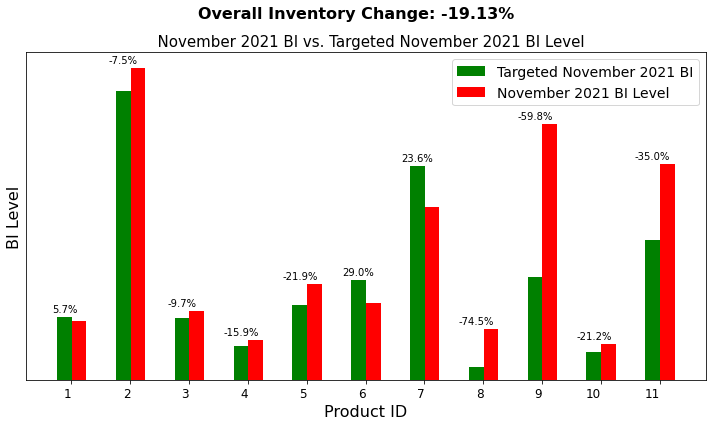

In [19]:
X = np.arange(len(prod_code) - 2) + 1  # Adjusting to start from 1 instead of 0

overall_change = ((asd['BI_TWCV'].sum() - asd['Beg_Inventory-X'].sum()) / asd['Beg_Inventory-X'].sum()) * 100

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(X, asd['BI_TWCV'][:len(X)].tolist(), color='g', width=0.25, label='Targeted November 2021 BI')
rects2 = ax.bar(X + 0.25, asd['Beg_Inventory-X'][:len(X)].tolist(), color='r', width=0.25, label='November 2021 BI Level')
def add_labels(rects1, rects2):
    for rect1, rect2 in zip(rects1, rects2):
        height1 = rect1.get_height()
        height2 = rect2.get_height()
        percentage_diff = ((height1 - height2) / height2) * 100
        ax.annotate(f'{percentage_diff:.1f}%', 
                    xy=(rect1.get_x() + rect1.get_width() / 2, max(height1, height2)),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
add_labels(rects1, rects2)
ax.set_title('  November 2021 BI vs. Targeted November 2021 BI Level', fontsize=15,loc='center')
ax.set_xlabel("Product ID", fontsize=16)
ax.set_ylabel("BI Level", fontsize=16)
ax.set_xticks(X + 0.12) 
ax.set_xticklabels(X[:len(X)], ha="right", fontsize=12)
ax.set_yticks([])
ax.legend(fontsize=14)
plt.suptitle(f'Overall Inventory Change: {overall_change:.2f}%', fontsize=16, fontweight='bold',ha='center')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()